In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from copy import deepcopy

import k3d
import yaml
import numpy as np

import matplotlib.pyplot as plt

from tqdm import tqdm
import json
# from PIL import Image
from base64 import b64decode
from IPython.display import Image

import time
import h5py

In [3]:
def display_sharpness(mesh=None, plot_meshvert=True,
                      samples=None, samples_distances=None,
                      sharp_vert=None, sharp_curves=None,
                      directions=None, directions_width=0.0025,
                      samples_color=0x0000ff, samples_psize=0.002, 
                      mesh_color=0xbbbbbb, meshvert_color=0x666666, meshvert_psize=0.0025,
                      sharpvert_color=0xff0000, sharpvert_psize=0.0025,
                      sharpcurve_color=None, sharpcurve_width=0.0025,
                      as_image=False, plot_height=768):
    
    plot = k3d.plot(height=plot_height)
    
    if None is not mesh:
        k3d_mesh = k3d.mesh(mesh.vertices, mesh.faces, color=mesh_color)
        plot += k3d_mesh

        if plot_meshvert:
            k3d_points = k3d.points(mesh.vertices, 
                                    point_size=meshvert_psize, color=meshvert_color)
            plot += k3d_points
            k3d_points.shader='3d'

    if None is not samples:
        colors = None
        if None is not samples_distances:
            max_dist = np.max(samples_distances)

            colors = k3d.helpers.map_colors(
                samples_distances, k3d.colormaps.basic_color_maps.WarmCool, [0, max_dist]
            ).astype(np.uint32)
            k3d_points = k3d.points(samples, point_size=samples_psize, colors=colors)
        else:
            k3d_points = k3d.points(samples, point_size=samples_psize, color=samples_color)
        plot += k3d_points
        k3d_points.shader='3d'
        
        if None is not directions:
            directions_to_plot = np.hstack((samples, samples + directions))
            
            for i, dir_to_plot in enumerate(directions_to_plot):
                dir_to_plot = dir_to_plot.reshape((2, 3))
                if np.all(dir_to_plot[0] == dir_to_plot[1]):
                    continue
                color = int(colors[i]) if None is not colors else samples_color
                plt_line = k3d.line(dir_to_plot, 
                                    shader='mesh', width=directions_width, color=color)
                plot += plt_line

    if None is not sharp_vert:
        k3d_points = k3d.points(sharp_vert,
                                point_size=sharpvert_psize, color=sharpvert_color)
        plot += k3d_points
        k3d_points.shader='3d'
        
        if None is not sharp_curves:            
            if None is not sharpcurve_color:
                color = sharpcurve_color
            else:
                import randomcolor
                rand_color = randomcolor.RandomColor()
            for i, vert_ind in enumerate(sharp_curves):
                sharp_points_curve = mesh.vertices[vert_ind]
                
                if None is sharpcurve_color:
                    color = rand_color.generate(hue='red')[0]
                    color = int('0x' + color[1:], 16)
                plt_line = k3d.line(sharp_points_curve, 
                                    shader='mesh', width=sharpcurve_width, color=color)
                plot += plt_line
        
    plot.grid_visible = False
    plot.camera_auto_fit = True
    plot.display()
    
    return plot

In [4]:
# mm/pixel
HIGH_RES = 0.02
MED_RES = 0.05
LOW_RES = 0.125
XLOW_RES = 0.25

## 1. Working with point patches

In [5]:
from sharpf.data.abc.abc_data import ABCModality, ABCChunk, ABC_7Z_FILEMASK
from sharpf.data.annotation import ANNOTATOR_BY_TYPE
from sharpf.data.mesh_nbhoods import NBHOOD_BY_TYPE
from sharpf.data.noisers import NOISE_BY_TYPE
from sharpf.data.point_samplers import SAMPLER_BY_TYPE
from sharpf.utils.common import eprint
from sharpf.utils.mesh_utils.io import trimesh_load

from sharpf.utils.abc_utils import (
    get_adjacent_features_by_bfs_with_depth1,
    build_surface_patch_graph,
    get_curves_extents,
    compute_features_nbhood,
    remove_boundary_features)
from sharpf.utils.geometry import dist_vector_proj, mean_mmd

In [61]:
f = h5py.File('/logs/images/abc_0022_4_5.hdf5', 'r')


images = np.array(f['image'])
distances = np.array(f['distances'])
print(np.array(f['num_surfaces']))
print(np.array(f['num_sharp_curves']))
item_ids = np.array(f['item_id'])

f.close()

[2 4 2 4 2 1]
[32 43 32 41 35 26]


In [62]:
distances.shape

(6, 512, 512)

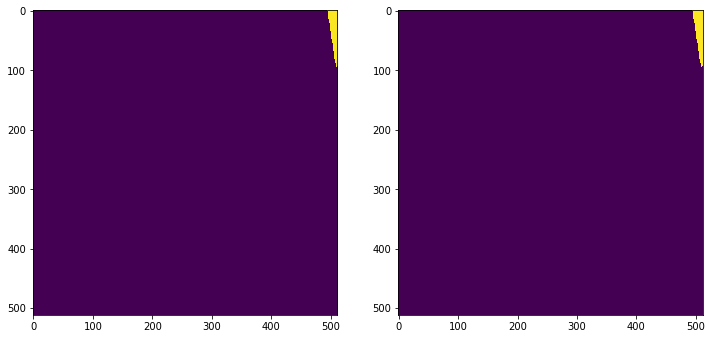

In [69]:
idx = 5
f, axs = plt.subplots(figsize=(12, 8), ncols=2)
axs[0].imshow(images[idx])
axs[1].imshow(distances[idx])

In [ ]:
with open('/code/scripts/data_scripts/configs/pointcloud_datasets/dataset_config_low_res_clean.json') as config_file:
    config = json.load(config_file)

config

In [ ]:
shape_fabrication_extent = config.get('shape_fabrication_extent', 10.0)
base_n_points_per_short_curve = config.get('base_n_points_per_short_curve', 8)
base_resolution_3d = config.get('base_resolution_3d', LOW_RES)
short_curve_quantile = config.get('short_curve_quantile', 0.05)

In [ ]:
def scale_mesh(mesh, features, shape_fabrication_extent, resolution_3d,
               short_curve_quantile=0.05, n_points_per_short_curve=4):
    # compute standard size spatial extent
    mesh_extent = np.max(mesh.bounding_box.extents)
    mesh = mesh.apply_scale(shape_fabrication_extent / mesh_extent)

    # compute lengths of curves
    sharp_curves_lengths = get_curves_extents(mesh, features)

    least_len = np.quantile(sharp_curves_lengths, short_curve_quantile)
    least_len_mm = resolution_3d * n_points_per_short_curve

    mesh = mesh.apply_scale(least_len_mm / least_len)
    print("Mesh extent post scaling:", np.max(mesh.bounding_box.extents))

    return mesh

In [ ]:
# meshes = []
# featuress = []
# with ABCChunk(['/data/abc_0056_obj_v00.7z', '/data/abc_0056_feat_v00.7z']) as data_holder:
#     for index in range(50):
#         item = data_holder[index]
#         meshes.append(trimesh_load(item.obj))
#         featuress.append(yaml.load(item.feat, Loader=yaml.Loader))

In [ ]:
# with ABCChunk(['/data/abc_0057_obj_v00.7z', '/data/abc_0057_feat_v00.7z']) as data_holder:
#     item = data_holder[2]
#     mesh = trimesh_load(item.obj)
#     features = yaml.load(item.feat, Loader=yaml.Loader)

In [ ]:
idx = 0
res_3d = LOW_RES

# mesh = meshes[idx]
# features = featuress[idx]

# # fix mesh fabrication size in physical mm
# mesh = scale_mesh(mesh, features, shape_fabrication_extent, base_resolution_3d,
#                   short_curve_quantile=short_curve_quantile,
#                   n_points_per_short_curve=base_n_points_per_short_curve)

# f = h5py.File('/logs/abc_005_{}_{}.hdf5'.format(res_3d, idx, idx + 1), 'r')
f = h5py.File('/logs/abc_0022_10_11.hdf5', 'r')


points = np.array(f['points'])
distances = np.array(f['distances'])
print(np.array(f['num_surfaces']))
print(np.array(f['num_sharp_curves']))



mesh_vertex_indexes = np.array(f['orig_vert_indices'])
mesh_face_indexes = np.array(f['orig_face_indexes'])

# samples = points[0]
samples = np.concatenate(points)
# samples_distances = distances[0]
samples_distances = np.concatenate(distances)

plot = display_sharpness(None, plot_meshvert=False, meshvert_psize=0.01,
                  sharp_vert=None, sharpvert_psize=0.1,
                  samples=samples, samples_distances=samples_distances,
                  samples_color=0x0000ff, samples_psize=res_3d)

f.close()

In [ ]:
plot.fetch_screenshot()

In [ ]:

from IPython.display import Image
with open('screenshot.png', 'wb') as f:
    try:
        out = plot.screenshot.decode('base64')
    except: # Python 3
        from base64 import b64decode
        out = b64decode(plot.screenshot)    
    f.write(out)
    
Image(url='screenshot.png')

In [ ]:
from collections import defaultdict

all_num_surfaces = defaultdict(list)
all_num_curves = defaultdict(list)

In [ ]:
for res_3d in [LOW_RES, MED_RES, HIGH_RES]:
    for idx in range(0, 50):
        try:
            f = h5py.File('/logs/test_generation/{}/abc_0056_{}_{}.hdf5'.format(res_3d, idx, idx + 1), 'r')
        except OSError:
            continue

        all_num_surfaces[res_3d].extend(np.array(f['num_surfaces']))
        all_num_curves[res_3d].extend(np.array(f['num_sharp_curves']))


        f.close()

In [ ]:
all_num_surfaces.keys()

In [ ]:
bins = np.linspace(0, 30, 31)

plt.figure(figsize=(12, 6))
plt.hist(all_num_surfaces[LOW_RES] , bins=bins, histtype='step', alpha=1.0, label='low-res 0.125 mm')
plt.hist(all_num_surfaces[MED_RES] , bins=bins, histtype='step', alpha=1.0, label='med-res 0.05 mm')
plt.hist(all_num_surfaces[HIGH_RES], bins=bins, histtype='step', alpha=1.0, label='high-res 0.02 mm')

plt.gca().set_yscale('log')
plt.gca().set_xscale('log')
plt.legend()

In [ ]:
from scipy.spatial import KDTree

In [ ]:
tree = KDTree(points[0], leafsize=100)


In [ ]:
_, vert_indices = tree.query(points[0], k=2)

In [ ]:
plt.hist(distances[0][vert_indices[:, 0]] - distances[0][vert_indices[:, 1]],
         bins=100)
plt.gca().set_yscale('log')

In [ ]:
from scipy.spatial import cKDTree

In [ ]:
patch_idx = 7

tree = KDTree(points[patch_idx], leafsize=100)

d, vert_indices = tree.query(points[patch_idx], k=2)

values = np.abs(distances[patch_idx][vert_indices[:, 0]] - distances[patch_idx][vert_indices[:, 1]]) / d[:, 1]
plt.hist(values, bins=100)
plt.gca().set_yscale('log')

In [ ]:
values[values > 1.0]

In [ ]:
for patch_idx, patch_points, patch_distances in zip(range(32), points, distances):
    nn_distances, vert_indices = cKDTree(patch_points, leafsize=16).query(patch_points, k=4096, n_jobs=16)
    values = np.abs(patch_distances[vert_indices[:, 0]] - patch_distances[vert_indices[:, 1]]) / nn_distances[:, 1]
    if np.any(values > 1.1):
        print(patch_idx, 'BAD')
    else:
        print(patch_idx, 'OK')


In [ ]:
from scipy.spatial import KDTree, cKDTree

In [ ]:
%time _ = KDTree(patch_points, leafsize=16).query(patch_points, k=2)

In [ ]:
%time _ = cKDTree(patch_points, leafsize=16).query(patch_points, k=2)

In [ ]:
patch_points.shape

In [ ]:
np.concatenate(points).shape

In [ ]:
import glob

In [ ]:
glob.glob('/logs/test_generation/*.hdf5')

In [ ]:
all_patches = 0
for filename in glob.glob('/logs/test_generation/*.hdf5'):
    try:
        f = h5py.File(filename, 'r')
    except OSError:
        continue

    has_sharp = np.array(f['has_sharp'])
    all_patches += len(has_sharp)
    
    f.close()

In [ ]:
all_patches

In [ ]:
f = h5py.File('/logs/images/abc_0022_7_8.hdf5', 'r')


images = np.array(f['image'])
distances = np.array(f['distances'])
print(np.array(f['num_surfaces']))
print(np.array(f['num_sharp_curves']))
item_ids = np.array(f['item_id'])

f.close()

In [ ]:
points.shape

In [ ]:
0.03125 / 4

In [ ]:
!ls /logs/test_generation/bobrg.hdf5

In [ ]:
res_3d = 0.125
scale = 0.03125
# scale = 0.0625
# scale = 0.125
# scale = 0.25
# scale = 0.5

f = h5py.File('/logs/test_generation/bobrg.hdf5', 'r')

image = np.array(f['image'])
normals = np.array(f['normals'])
# item_ids = np.array(f['item_id'])
# mesh_vertex_indexes = np.array(f['orig_vert_indices'])
# mesh_face_indexes = np.array(f['orig_face_indexes'])

# # idx = np.where(item_ids == np.unique(item_ids)[3])[0]
# samples = points[11]
# # samples = np.concatenate(points)
# samples_distances = distances[11]
# # samples_distances = np.concatenate(distances[idx])

# plot = display_sharpness(None, plot_meshvert=False, meshvert_psize=0.01,
#                   sharp_vert=None, sharpvert_psize=0.1,
#                   samples=samples, samples_distances=samples_distances,
#                   samples_color=0x0000ff, samples_psize=res_3d)

f.close()

In [ ]:
plt.imshow(np.squeeze(normals))

In [ ]:
points = np.random.normal(size=(4*4096, 3))
distances = np.random.normal(size=(4*4096))

In [ ]:
from scipy.spatial import cKDTree

In [ ]:
nn_distances, nn_indexes = cKDTree(points, leafsize=16).query(points, k=2, n_jobs=2)
data_slices = [(start, start + 4096) for start in range(0, len(nn_indexes), 4096)]
for start, end in data_slices:
    indexes = np.arange(start, end)
    values = np.abs(distances[nn_indexes[indexes, 0]] - distances[nn_indexes[indexes, 1]]) / nn_distances[indexes, 1]
    if np.any(values > 1.1):
        print('Discontinuities found in SDF values, discarding patch')
